In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import numpy as np
import torch.onnx 
import torchvision
from sklearn.model_selection import train_test_split
%matplotlib inline
from mycnn_lib import *
input_img_sz=11
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="../../data",    
    train=True,
    download=True,
    transform=torchvision.transforms.Compose(
    [torchvision.transforms.Resize(input_img_sz), torchvision.transforms.ToTensor()]
    ),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="../../data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose(
        [torchvision.transforms.Resize(input_img_sz), torchvision.transforms.ToTensor()]
    ),
)

In [2]:
import TCB
def D2reg(num,reg_name):
    if(num==0):
        return None
    else:
        tcb_str=TCB.Bin2TCB(int(num))
        temp=0
        if(num>0):
            out_s="+(0"
        else:
            out_s="-(0"
        for s in reversed(tcb_str):
            if(s=="+"):
                out_s+="+("+reg_name+"<<"+str(temp)+")"
            if(s=="-"):
                out_s+="-("+reg_name+"<<"+str(temp)+")"
            temp+=1         
            
        return out_s+")"
D2reg(-29,"reg")        


'-(0+(reg<<0)-(reg<<2)+(reg<<5))'

In [3]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # 11x11
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=2)    
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)                       
        self.fc1 = nn.Linear(25, 64)
        self.fc2 = nn.Linear(64, 10)
        

        
    def forward(self, x):
        # first conv
        x = self.pool(F.relu(self.conv1(x)))
        # flatten all dimensions except batch
        x = torch.flatten(x, 1)
        # fully connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        # print(np.amax(x.cpu().numpy()))
        

        return x

model = ConvNet().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()

# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3)
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Using cuda device
ConvNet(
  (conv1): Conv2d(1, 1, kernel_size=(2, 2), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=10, bias=True)
)
Shape of X [N, C, H, W]: torch.Size([64, 1, 11, 11])
Shape of y: torch.Size([64]) torch.int64


In [6]:
img,idx=test_data[0]

def M_time():
    model(img.reshape((1,1,11,11)).to(device))

%timeit for _ in range(1000): M_time()

214 ms ± 487 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


5


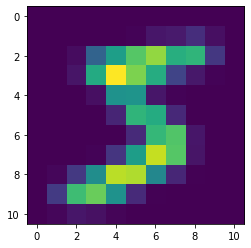

In [4]:
import matplotlib.pyplot as plt
img,idx =training_data[0]
print(idx)
plt.imshow(  img.permute(1, 2, 0)  )

In [4]:
import os
file_name = "cnn_c_maxpool_f_f94.4.pth"
if not (os.path.isfile(file_name)):
    epochs = 50
    for t in range(epochs):
        print(f"Epoch {t+1}\n-------------------------------")
        train(train_dataloader, model, loss_fn, optimizer)
        test(test_dataloader, model, loss_fn)
        torch.save(model, file_name)
    print("Done!")
else:
    #model.load_state_dict(torch.load("model.pth"))
    model = torch.load( file_name)
    test(test_dataloader, model, loss_fn)
    print("Model loaded")

Test Error: 
 Accuracy: 94.8%, Avg loss: 0.162365 

Model loaded


In [5]:

model = torch.load( file_name)
bit_range=8
for ele in model.state_dict():#turn to numpy
    model.state_dict()[ele]=model.state_dict()[ele].cpu().numpy()
#turn float to int
for layers in model.state_dict():
    try:
        (channel,num,row,col)=model.state_dict()[layers].shape
        for ch in range(channel):
            for r in range(row):
                for c in range(col):
                    num=int((model.state_dict()[layers][ch][0][r][c]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    model.state_dict()[layers][ch][0][r][c]=num
    except:
        try:
            model.state_dict()[layers].shape[1]## if parameter is 2D
            row,col=model.state_dict()[layers].shape
            for row in range(model.state_dict()[layers].shape[0]):
                for col in range(model.state_dict()[layers].shape[1]):
                    num=int((model.state_dict()[layers][row][col]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    model.state_dict()[layers][row][col]=num
        except:
            #model[layers].shape #1D
            # print(model[layers].shape[0])
            for i in range(model.state_dict()[layers].shape[0]):
                num=int((model.state_dict()[layers][i]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                model.state_dict()[layers][i]=num
test(test_dataloader, model, loss_fn)

Test Error: 
 Accuracy: 91.6%, Avg loss: 382075.333350 



model = torch.load( file_name)
A=29
bit_range=8
for ele in model.state_dict():#turn to numpy
    model.state_dict()[ele]=model.state_dict()[ele].cpu().numpy()
#turn float to int
for layers in model.state_dict():
    try:
        (channel,num,row,col)=model.state_dict()[layers].shape
        for ch in range(channel):
            for r in range(row):
                for c in range(col):
                    num=int((model.state_dict()[layers][ch][0][r][c]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    num=round(num/A)*A
                    model.state_dict()[layers][ch][0][r][c]=num
    except:
        try:
            model.state_dict()[layers].shape[1]## if parameter is 2D
            row,col=model.state_dict()[layers].shape
            for row in range(model.state_dict()[layers].shape[0]):
                for col in range(model.state_dict()[layers].shape[1]):
                    num=int((model.state_dict()[layers][row][col]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                    num=round(num/A)*A
                    model.state_dict()[layers][row][col]=num
        except:
            #model[layers].shape #1D
            # print(model[layers].shape[0])
            for i in range(model.state_dict()[layers].shape[0]):
                num=int((model.state_dict()[layers][i]+1)/2*(2**bit_range-1)-(2**(bit_range-1)-1))
                num=round(num/A)*A
                model.state_dict()[layers][i]=num
test(test_dataloader, model, loss_fn)

In [24]:
def mynet(times):
    for i in range(times):
        img,idx=test_data[i]
        img=int_conver(img.cpu().numpy())
        con_w=np.asarray(model.state_dict()["conv1.weight"].cpu())
        con_b=np.asarray(model.state_dict()["conv1.bias"].cpu())
        
        x=conv_sz(img,con_w,2)
        x=x+con_b
        # print(x) 
        # print("con",len(bin(int(max(x.reshape(-1))))))
        x=myRelu(x)
        x=myPool(x)
        x=x.reshape(-1)
        fc1_b=np.asarray(model.state_dict()["fc1.bias"].cpu())
        fc1_w=np.asarray(model.state_dict()["fc1.weight"].cpu())
        x=FullyConnected(x,fc1_w,fc1_b)
        x=myRelu(x)

        # print("fc1",len(bin(int(max(x)))))
        fc2_b=np.asarray(model.state_dict()["fc2.bias"].cpu())
        fc2_w=np.asarray(model.state_dict()["fc2.weight"].cpu())
        x=FullyConnected(x,fc2_w,fc2_b)


In [26]:
%timeit for _ in range(1000): mynet(1)

5.18 s ± 16.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
con_w=np.asarray(model.state_dict()["conv1.weight"].cpu())
con_b=np.asarray(model.state_dict()["conv1.bias"].cpu())
def mynet_ver2(times):
    for i in range(times):
        img,idx=test_data[i]
        img=int_conver(img.cpu().numpy())
        
        
        x=conv_sz(img,con_w,2)
        x=x+con_b
        # print(x) 
        # print("con",len(bin(int(max(x.reshape(-1))))))
        x=myRelu(x)
        x=myPool(x)
        x=x.reshape(-1)
        fc1_b=np.asarray(model.state_dict()["fc1.bias"].cpu())
        fc1_w=np.asarray(model.state_dict()["fc1.weight"].cpu())
        x=FullyConnected(x,fc1_w,fc1_b)
        x=myRelu(x)

        # print("fc1",len(bin(int(max(x)))))
        fc2_b=np.asarray(model.state_dict()["fc2.bias"].cpu())
        fc2_w=np.asarray(model.state_dict()["fc2.weight"].cpu())
        x=FullyConnected(x,fc2_w,fc2_b)
%timeit for _ in range(1000): mynet_ver2(1)

5.42 s ± 23.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
#Test0 verilog output
hit=0
from mycnn_lib import int_conver
for i in range(100):
    img,idx=test_data[i]
    img=int_conver(img.cpu().numpy())
    con_w=np.asarray(model.state_dict()["conv1.weight"].cpu())
    con_b=np.asarray(model.state_dict()["conv1.bias"].cpu())
    
    x=conv_sz(img,con_w,2)
    x=x+con_b
    # print(x) 
    # print("con",len(bin(int(max(x.reshape(-1))))))
    x=myRelu(x)
    x=myPool(x)
    x=x.reshape(-1)
    fc1_b=np.asarray(model.state_dict()["fc1.bias"].cpu())
    fc1_w=np.asarray(model.state_dict()["fc1.weight"].cpu())
    x=FullyConnected(x,fc1_w,fc1_b)
    x=myRelu(x)

    # print("fc1",len(bin(int(max(x)))))
    fc2_b=np.asarray(model.state_dict()["fc2.bias"].cpu())
    fc2_w=np.asarray(model.state_dict()["fc2.weight"].cpu())
    x=FullyConnected(x,fc2_w,fc2_b)

    # print("fc2",len(bin(int(max(x)))))
#     # print("predict",x.argmax(),"label",idx)
    if(x.argmax()==idx):
        hit+=1
print(hit)

97


In [ ]:
with open ('../verilog/con_tcb.v','w') as f:
    f.write("\
module con_tcb\n\
    #(\n\
        parameter   OUTPUT_BIT  =   19,\n\
                    OUTPUT_NODE =   100,\n\
                    DATA_WIDTH  =   19,\n\
                    IMG_SZ    =   11*11\n\
)\n\
(\n\
    input   clk,\n\
    input   rst,\n\
    input   [IMG_SZ*8-1:0]   img,\n\
    input   valid,\n\
    output  reg ready,\n\
    output [OUTPUT_BIT*OUTPUT_NODE-1:0] layer_out\n\
);\n\
\n\
reg    signed [8-1:0]  in_buffer[0:IMG_SZ-1];\n\
genvar j;\n\
generate\n\
for(j=0;j<IMG_SZ;j=j+1) \n\
    begin:init_block\n\
        always@(posedge clk)\n\
            begin\n\
                if(rst)\n\
                    begin\n\
                        in_buffer[j]<=0;\n\
                    end\n\
                else\n\
                    begin\n\
                        in_buffer[j]<=img[j*8+7:j*8+0];\n\
                    end\n\
            end\n\
    end\n\
endgenerate\n")
    #in buffer weight wire declaration
    f.write("//wire declatation\n")
    layer_output_node_count = 100
    for buffer_weight_cnt in range(layer_output_node_count):
        obj_now ="in_buffer_weight"+str(buffer_weight_cnt)
        f.write("wire signed    [DATA_WIDTH-1:0]   "+obj_now+";\n")
    #convolution 
    parameter_now=model.state_dict()["conv1.weight"].cpu().numpy()
    parameter_now=parameter_now.reshape(-1)
    #in buffer weight = in buffer (*) con_weight
    img_sample = np.arange(0,121).reshape(11,11)
    img_sz=11
    sz=2
    for col in range(img_sz-2+1):
            for row in range(img_sz-2+1):
                start_x,start_y=(col,row)
                member_in_sample = img_sample[start_x+0:start_x+sz,start_y+0:start_y+sz].reshape(-1)
                in_buffer_weight_index=col*10+row
                f.write("assign in_buffer_weight"+str(in_buffer_weight_index)+"=0")
                for i in range(4):
                    convolution_weight=parameter_now[i]
                    img_value=member_in_sample[i]
                    name ="in_buffer["+str(img_value)+"]"
                    number =int(convolution_weight)
                    try:
                        f.write(D2reg(number,name))
                    except:
                        pass
                    # f.write(str(int(convolution_weight))+"*")
                    # f.write("in_buffer["+str(img_value)+"]")
                    # if(i==3):
                    #     pass
                    # else:
                    #     f.write("+")
                f.write(";\n")
    #weight bias wire declaration
    parameter_now=model.state_dict()["conv1.bias"].cpu().numpy()
    parameter_now=parameter_now.reshape(-1)
    #add Bias 
    for weight_bias_cnt in range(layer_output_node_count):
        obj_now ="weight_bias"+str(weight_bias_cnt)
        f.write("wire signed    [DATA_WIDTH-1:0]   "+obj_now+";\n")
        f.write("assign "+obj_now+"= in_buffer_weight"+str(weight_bias_cnt)+"+"+str(int(parameter_now))+";\n")
    #bias relu wire declaration
    for bias_relu in range(layer_output_node_count):
        obj_now ="bias_relu"+str(bias_relu)
        f.write("wire signed    [DATA_WIDTH-1:0]   "+obj_now+";\n")
    #Relu
    for relu_cnt in range(layer_output_node_count):
        obj_now ="bias_relu"+str(relu_cnt)
        f.write("assign "+obj_now+"=(weight_bias"+str(relu_cnt)+"[DATA_WIDTH-1]==1'b1)   ?   {DATA_WIDTH{1'b0}}:weight_bias"+str(relu_cnt)+";\n")
    #Output layer 
    f.write("assign layer_out={\n")
    for out_cnt in range(layer_output_node_count-1,-1,-1):
        f.write("bias_relu"+str(out_cnt))
        if(out_cnt==0):
            pass
        else:
            f.write(",")
    f.write("};\n")
    f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready<=valid;\n\
            end\n\
    end\n")
    f.write("endmodule")

In [8]:
with open ('../verilog/convolution.v','w') as f:
    f.write("\
module convolution\n\
    #(\n\
        parameter   OUTPUT_BIT  =   19,\n\
                    OUTPUT_NODE =   100,\n\
                    DATA_WIDTH  =   19,\n\
                    IMG_SZ    =   11*11\n\
)\n\
(\n\
    input   clk,\n\
    input   rst,\n\
    input   [IMG_SZ*8-1:0]   img,\n\
    input   valid,\n\
    output  reg ready,\n\
    output [OUTPUT_BIT*OUTPUT_NODE-1:0] layer_out\n\
);\n\
\n\
reg    signed [8-1:0]  in_buffer[0:IMG_SZ-1];\n\
genvar j;\n\
generate\n\
for(j=0;j<IMG_SZ;j=j+1) \n\
    begin:init_block\n\
        always@(posedge clk)\n\
            begin\n\
                if(rst)\n\
                    begin\n\
                        in_buffer[j]<=0;\n\
                    end\n\
                else\n\
                    begin\n\
                        in_buffer[j]<=img[j*8+7:j*8+0];\n\
                    end\n\
            end\n\
    end\n\
endgenerate\n")
    #in buffer weight wire declaration
    f.write("//wire declatation\n")
    layer_output_node_count = 100
    for buffer_weight_cnt in range(layer_output_node_count):
        obj_now ="in_buffer_weight"+str(buffer_weight_cnt)
        f.write("wire signed    [DATA_WIDTH-1:0]   "+obj_now+";\n")
    #convolution 
    parameter_now=model.state_dict()["conv1.weight"].cpu().numpy()
    parameter_now=parameter_now.reshape(-1)
    #in buffer weight = in buffer (*) con_weight
    img_sample = np.arange(0,121).reshape(11,11)
    img_sz=11
    sz=2
    for col in range(img_sz-2+1):
            for row in range(img_sz-2+1):
                start_x,start_y=(col,row)
                member_in_sample = img_sample[start_x+0:start_x+sz,start_y+0:start_y+sz].reshape(-1)
                in_buffer_weight_index=col*10+row
                f.write("assign in_buffer_weight"+str(in_buffer_weight_index)+"=")
                for i in range(4):
                    convolution_weight=parameter_now[i]
                    img_value=member_in_sample[i]
                    # name ="in_buffer["+str(img_value)+"]"
                    # number =int(convolution_weight)
                    # try:
                    #     f.write(D2reg(number,name))
                    # except:
                    #     pass

                    f.write("$signed(("+str(int(convolution_weight))+")*")
                    f.write("in_buffer["+str(img_value)+"])")
                    if(i==3):
                        pass
                    else:
                        f.write("+")
                f.write(";\n")
    #weight bias wire declaration
    parameter_now=model.state_dict()["conv1.bias"].cpu().numpy()
    parameter_now=parameter_now.reshape(-1)
    #add Bias 
    for weight_bias_cnt in range(layer_output_node_count):
        obj_now ="weight_bias"+str(weight_bias_cnt)
        f.write("wire signed    [DATA_WIDTH-1:0]   "+obj_now+";\n")
        f.write("assign "+obj_now+"= in_buffer_weight"+str(weight_bias_cnt)+"+"+str(int(parameter_now))+";\n")
    #bias relu wire declaration
    for bias_relu in range(layer_output_node_count):
        obj_now ="bias_relu"+str(bias_relu)
        f.write("wire signed    [DATA_WIDTH-1:0]   "+obj_now+";\n")
    #Relu
    for relu_cnt in range(layer_output_node_count):
        obj_now ="bias_relu"+str(relu_cnt)
        f.write("assign "+obj_now+"=(weight_bias"+str(relu_cnt)+"[DATA_WIDTH-1]==1'b1)   ?   {DATA_WIDTH{1'b0}}:weight_bias"+str(relu_cnt)+";\n")
    #Output layer 
    f.write("assign layer_out={\n")
    for out_cnt in range(layer_output_node_count-1,-1,-1):
        f.write("bias_relu"+str(out_cnt))
        if(out_cnt==0):
            pass
        else:
            f.write(",")
    f.write("};\n")
    f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready<=valid;\n\
            end\n\
    end\n")
    f.write("endmodule")

In [10]:
#py_out pic test
destination= "./py_out/"
file_name ='pic_test_input.txt'
with open (destination+file_name,'w') as f:
#     f.write("initial\n\
# begin\n\
#     clk=0;valid=1'b1;rst=1'b1;\n\
#     @(negedeg clk) #(10/4)\n\
#     begin\n\
#     rst=1'b0;\n\
#     in_img ={(IMG_SZ*8){1'b0}};\n\
# end\n\
#         ")
    test_len=1000
    for test_img_idx in range(test_len):
        f.write("@(negedge clk) #(10/4) \n")
        f.write("   begin\n")
        f.write("       img="+str(input_img_sz*input_img_sz*8)+"'b")
        img,idx=test_data[test_img_idx]
        # img,idx=test_data[1]
        print(idx)
        img=img.reshape(-1)
        img=np.asarray(img)
        img=int_conver(img)
        for ele in reversed(img):
            eight_bit="{:08b}".format(int(ele))
            f.write(eight_bit)
            #print(ele)
        f.write(";\n")
        f.write("   end\n")
        f.write("#10 ;")
    # f.write("#100 $finish;\n")

destination= "./py_out/"
file_name ='label.mem'
with open (destination+file_name,'w') as f:
    for test_img_idx in range(test_len):
        img,idx=test_data[test_img_idx]
        f.write(str(idx))
        f.write("\n")


7
2
1
0
4
1
4
9
5
9
0
6
9
0
1
5
9
7
3
4
9
6
6
5
4
0
7
4
0
1
3
1
3
4
7
2
7
1
2
1
1
7
4
2
3
5
1
2
4
4
6
3
5
5
6
0
4
1
9
5
7
8
9
3
7
4
6
4
3
0
7
0
2
9
1
7
3
2
9
7
7
6
2
7
8
4
7
3
6
1
3
6
9
3
1
4
1
7
6
9
6
0
5
4
9
9
2
1
9
4
8
7
3
9
7
4
4
4
9
2
5
4
7
6
7
9
0
5
8
5
6
6
5
7
8
1
0
1
6
4
6
7
3
1
7
1
8
2
0
2
9
9
5
5
1
5
6
0
3
4
4
6
5
4
6
5
4
5
1
4
4
7
2
3
2
7
1
8
1
8
1
8
5
0
8
9
2
5
0
1
1
1
0
9
0
3
1
6
4
2
3
6
1
1
1
3
9
5
2
9
4
5
9
3
9
0
3
6
5
5
7
2
2
7
1
2
8
4
1
7
3
3
8
8
7
9
2
2
4
1
5
9
8
7
2
3
0
4
4
2
4
1
9
5
7
7
2
8
2
6
8
5
7
7
9
1
8
1
8
0
3
0
1
9
9
4
1
8
2
1
2
9
7
5
9
2
6
4
1
5
8
2
9
2
0
4
0
0
2
8
4
7
1
2
4
0
2
7
4
3
3
0
0
3
1
9
6
5
2
5
9
2
9
3
0
4
2
0
7
1
1
2
1
5
3
3
9
7
8
6
5
6
1
3
8
1
0
5
1
3
1
5
5
6
1
8
5
1
7
9
4
6
2
2
5
0
6
5
6
3
7
2
0
8
8
5
4
1
1
4
0
3
3
7
6
1
6
2
1
9
2
8
6
1
9
5
2
5
4
4
2
8
3
8
2
4
5
0
3
1
7
7
5
7
9
7
1
9
2
1
4
2
9
2
0
4
9
1
4
8
1
8
4
5
9
8
8
3
7
6
0
0
3
0
2
6
6
4
9
3
3
3
2
3
9
1
2
6
8
0
5
6
6
6
3
8
8
2
7
5
8
9
6
1
8
4
1
2
5
9
1
9
7
5
4
0
8
9
9
1
0
5
2
3
7
8
9
4
0
6


In [31]:
#py_out maxpool
destination= "../verilog/"
file_name ='max_pool.v'

with open (destination+file_name,'w') as f:

    f.write("\
module maxpool\n\
    #(\n\
        parameter   INPUT_BIT   =   19,\n\
                    INPUT_NODE  =   100,\n\
                    OUTPUT_NODE =   25,\n\
                    DATA_WIDTH  =   19\n\
)\n\
(\n\
    input   clk,\n\
    input   rst,\n\
    input   [INPUT_BIT*INPUT_NODE-1:0] layer_in,\n\
    input   valid,\n\
    output  reg ready,\n\
    output [INPUT_BIT*OUTPUT_NODE-1:0] layer_out\n\
);\n\
reg    signed [DATA_WIDTH-1:0]  in_buffer[0:INPUT_NODE-1];\n\
genvar j;\n\
generate\n\
for(j=0;j<INPUT_NODE;j=j+1) \n\
    begin:init_block\n\
        always@(posedge clk)\n\
            begin\n\
                if(rst)\n\
                    begin\n\
                        in_buffer[j]<=0;\n\
                    end\n\
                else\n\
                    begin\n\
                        in_buffer[j]<=layer_in[j*DATA_WIDTH+(DATA_WIDTH-1):j*DATA_WIDTH+0];\n\
                    end\n\
            end\n\
    end\n\
endgenerate\n")
    
    sample_buffer = np.arange(0,100).reshape((10,10))
    step=int(10/2)
    for row in range(step):
            for col in range(step):
                start_x,start_y=(row,col)
                comparison_member =sample_buffer[start_x*2+0:start_x*2+2,start_y*2+0:start_y*2+2].reshape(-1)
                comparison_phase0_object0 ="com_"+str(comparison_member[0])+"_"+str(comparison_member[1])
                comparison_phase0_object1 ="com_"+str(comparison_member[2])+"_"+str(comparison_member[3])
                out_idx = col+row*5
                comparison_phase1_object0 ="com_out"+str(out_idx)+"_"+str(comparison_member[0])+"_"+str(comparison_member[1])+"_"+str(comparison_member[2])+"_"+str(comparison_member[3])
                f.write("wire [DATA_WIDTH-1:0] "+comparison_phase0_object0+";\n")
                f.write("wire [DATA_WIDTH-1:0] "+comparison_phase0_object1+";\n")
                f.write("wire [DATA_WIDTH-1:0] "+comparison_phase1_object0+";\n")
                buffer_name0="in_buffer["+str(comparison_member[0])+"]"
                buffer_name1="in_buffer["+str(comparison_member[1])+"]"
                buffer_name2="in_buffer["+str(comparison_member[2])+"]"
                buffer_name3="in_buffer["+str(comparison_member[3])+"]"
                f.write("assign "+comparison_phase0_object0+"   =  ("+buffer_name0+">"+buffer_name1+")\
    ?   "+buffer_name0+":"+buffer_name1+";\n")
                f.write("assign "+comparison_phase0_object1+"   =  ("+buffer_name2+">"+buffer_name3+")\
    ?   "+buffer_name2+":"+buffer_name3+";\n")
                f.write("assign "+comparison_phase1_object0+"   =   ("+comparison_phase0_object0+">"+comparison_phase0_object1+")\
    ?   "+comparison_phase0_object0+":"+comparison_phase0_object1+";\n")
                square = "DATA_WIDTH*"+str(out_idx)
                f.write("assign layer_out   [DATA_WIDTH+"+square+"-1:0+"+square+"]    ="+comparison_phase1_object0+";\n")


    f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready<=valid;\n\
            end\n\
    end\n")
    f.write("endmodule\n")

In [32]:
#layer0
input_img_bit_size=input_img_sz*input_img_sz
wire_cnt=25
in_buffer_weight_name="in_buffer_weight"
weight_to_bias_name="weight_bias"
bias_relu_name="bias_relu"
in_buffer_weight_parameter=np.asarray(model.state_dict()["fc1.weight"].cpu().numpy())
weight_bias_parameter=np.asarray(model.state_dict()["fc1.bias"].cpu().numpy())
last_layer_bit=19

data_bit_num=27
output_num=64
layer0_verilog_file_name="layer0_tcbcnn_"+str(input_img_bit_size)+"_25x64x10"
f=open("../verilog/"+layer0_verilog_file_name+".v","w")
f.write("module "+layer0_verilog_file_name+"\n")

f.write("(\n")
input_bit_size = last_layer_bit*wire_cnt
f.write("\
    input clk,\n\
    input rst,\n\
    input ["+str(input_bit_size)+"-1:0] layer_in,\n\
    input valid,\n\
    output  reg ready,\n\
    output ["+str(data_bit_num)+"*"+str(output_num)+"-1:0] layer_out\n"\
)
f.write(");\n")
f.write("parameter DATA_WIDTH = "+str(data_bit_num)+";\n")
f.write("parameter INPUT_DATA_CNT   =   "+str(wire_cnt)+";\n")

f.write("reg    signed [DATA_WIDTH-1:0]  in_buffer[0:INPUT_DATA_CNT-1];\n")
f.write("genvar j;\n\
generate\n\
for(j=0;j<INPUT_DATA_CNT;j=j+1) \n\
    begin:init_block\n\
        always@(posedge clk)\n\
            begin\n\
                if(rst)\n\
                    begin\n\
                        in_buffer[j]<=0;\n\
                    end\n\
                else\n\
                    begin\n\
                        in_buffer[j]<=layer_in[j*"+str(last_layer_bit)+"+"+str(last_layer_bit-1)+":j*"+str(last_layer_bit)+"+0];\n\
                    end\n\
            end\n\
    end\n\
endgenerate\n")



for naming_idx in range(output_num): 
    f.write("wire signed  [DATA_WIDTH-1:0]   ")   
    f.write(in_buffer_weight_name+str(naming_idx)+";\n")
    f.write("assign "+in_buffer_weight_name+str(naming_idx)+"=0")
    #insert tcb
    for in_buf_idx in range(wire_cnt):
        name="in_buffer[" +str(in_buf_idx)+"]"
        num=int(in_buffer_weight_parameter[naming_idx][in_buf_idx])
        try:
            f.write(D2reg(num,name))
        except:
            pass
    f.write(";\n")

#weight0 to bias0
previous_layer_name=in_buffer_weight_name
#naming wire
print("wire_cnt",wire_cnt)
for naming_idx in range(output_num): 
    f.write("wire signed [DATA_WIDTH-1:0]   ")   
    f.write(weight_to_bias_name+str(naming_idx)+";\n")
for naming_idx in range(output_num):
    f.write("assign "+weight_to_bias_name+str(naming_idx)+"=")
    f.write(previous_layer_name+str(naming_idx))
    f.write("+(")
    f.write(str(int(weight_bias_parameter[naming_idx])))

    f.write(");\n")
#bias0 to relu0
previous_layer_name=weight_to_bias_name
#naming wire
print("wire_cnt",output_num)
for naming_idx in range(output_num): 
    f.write("wire signed [DATA_WIDTH-1:0]   ")   
    f.write(bias_relu_name+str(naming_idx)+";\n")
for naming_idx in range(output_num):
    f.write("assign "+bias_relu_name+str(naming_idx)+"=(")
    f.write(previous_layer_name+str(naming_idx))
    f.write("[DATA_WIDTH-1]==1'b1)   ?   ")
    f.write("{DATA_WIDTH{1'b0}}:")
    f.write(previous_layer_name+str(naming_idx))
    f.write(";\n")


f.write("assign layer_out={")
for naming_idx in range(output_num-1,-1,-1):
    if(naming_idx==0):
        f.write(bias_relu_name+str(naming_idx))
    else:
        f.write(bias_relu_name+str(naming_idx)+",")
f.write("};\n")
f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready<=valid;\n\
            end\n\
    end\n")
f.write("endmodule")
f.close()


wire_cnt 25
wire_cnt 64


In [33]:
#layer1
input_img_bit_size=input_img_sz*input_img_sz
wire_cnt=64
in_buffer_weight_name="in_buffer_weight"
weight_to_bias_name="weight_bias"
bias_relu_name="bias_relu"
in_buffer_weight_parameter=np.asarray(model.state_dict()["fc2.weight"].cpu().numpy())
weight_bias_parameter=np.asarray(model.state_dict()["fc2.bias"].cpu().numpy())
last_layer_bit =27
data_bit_num=36
output_num=10
layer0_verilog_file_name="layer1_tcbcnn_"+str(input_img_bit_size)+"_25x64x10"
f=open("../verilog/"+layer0_verilog_file_name+".v","w")
f.write("module "+layer0_verilog_file_name+"\n")

f.write("(\n")
input_bit_size = last_layer_bit*wire_cnt
f.write("\
    input clk,\n\
    input rst,\n\
    input ["+str(input_bit_size)+"-1:0] layer_in,\n\
    input valid,\n\
    output  reg ready,\n\
    output ["+str(data_bit_num)+"*"+str(output_num)+"-1:0] layer_out\n"\
)
f.write(");\n")
f.write("parameter DATA_WIDTH = "+str(data_bit_num)+";\n")
f.write("parameter INPUT_DATA_CNT   =   "+str(wire_cnt)+";\n")

f.write("reg    signed ["+str(last_layer_bit)+"-1:0]  in_buffer[0:INPUT_DATA_CNT-1];\n")
f.write("genvar j;\n\
generate\n\
for(j=0;j<INPUT_DATA_CNT;j=j+1) \n\
    begin:init_block\n\
        always@(posedge clk)\n\
            begin\n\
                if(rst)\n\
                    begin\n\
                        in_buffer[j]<=0;\n\
                    end\n\
                else\n\
                    begin\n\
                        in_buffer[j]<=layer_in[j*"+str(last_layer_bit)+"+"+str(last_layer_bit-1)+":j*"+str(last_layer_bit)+"+0];\n\
                    end\n\
            end\n\
    end\n\
endgenerate\n")



for naming_idx in range(output_num): 
    f.write("wire signed  [DATA_WIDTH-1:0]   ")   
    f.write(in_buffer_weight_name+str(naming_idx)+";\n")
    f.write("assign "+in_buffer_weight_name+str(naming_idx)+"=0")
    #insert tcb
    for in_buf_idx in range(wire_cnt):
        name="in_buffer[" +str(in_buf_idx)+"]"
        num=int(in_buffer_weight_parameter[naming_idx][in_buf_idx])
        try:
            f.write(D2reg(num,name))
        except:
            pass
    f.write(";\n")

#weight0 to bias0
previous_layer_name=in_buffer_weight_name
#naming wire
print("wire_cnt",wire_cnt)
for naming_idx in range(output_num): 
    f.write("wire signed [DATA_WIDTH-1:0]   ")   
    f.write(weight_to_bias_name+str(naming_idx)+";\n")
for naming_idx in range(output_num):
    f.write("assign "+weight_to_bias_name+str(naming_idx)+"=")
    f.write(previous_layer_name+str(naming_idx))
    f.write("+(")
    f.write(str(int(weight_bias_parameter[naming_idx])))

    f.write(");\n")
f.write("assign layer_out={")
for naming_idx in range(output_num-1,-1,-1):
    if(naming_idx==0):
        f.write(weight_to_bias_name+str(naming_idx))
    else:
        f.write(weight_to_bias_name+str(naming_idx)+",")
f.write("};\n")
f.write("always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready<=valid;\n\
            end\n\
    end\n")
f.write("endmodule")
f.close()


wire_cnt 64


In [34]:
#comparator
input_data_width =36
with open("../verilog/comparator_anybit.v","w") as f:
    f.write("\
module comparator\n\
(\n\
input ["+str(input_data_width)+"*10-1:0] layer_out,\n\
input rst,\n\
input clk,\n\
input valid,\n\
output  reg ready,\n\
output reg [31:0] predict\n\
);\n\
parameter DATA_WIDTH="+str(input_data_width)+";\n\
reg [DATA_WIDTH-1: 0] result [0:9];\n\
wire [4+DATA_WIDTH-1:0] com_re01,com_re23,com_re45,com_re67,com_re89;\n\
reg ready_temp;\n\
always@(posedge clk)\n\
    begin\n\
        if(rst)\n\
            begin\n\
                ready<=1'b0;\n\
                ready_temp<=1'b0;\n\
            end\n\
        else\n\
            begin\n\
                ready_temp<=valid;\n\
                ready<=ready_temp;\n\
            end\n\
    end\n\
 \n\
assign com_re01=(result[0][DATA_WIDTH-1]^result[1][DATA_WIDTH-1]) ? \n\
                                                        ((result[0][DATA_WIDTH-1]==1'b0)   ?   {4'd0,result[0]}:{4'd1,result[1]}):\n\
                                                        ((result[0]>result[1]) ? {4'd0,result[0]}:{4'd1,result[1]});\n\
assign com_re23=(result[2][DATA_WIDTH-1]^result[3][DATA_WIDTH-1]) ? \n\
                                                        ((result[2][DATA_WIDTH-1]==1'b0)   ?   {4'd2,result[2]}:{4'd3,result[3]}):\n\
                                                        ((result[2]>result[3]) ? {4'd2,result[2]}:{4'd3,result[3]});\n\
assign com_re45=(result[4][DATA_WIDTH-1]^result[5][DATA_WIDTH-1]) ? \n\
                                                        ((result[4][DATA_WIDTH-1]==1'b0)   ?   {4'd4,result[4]}:{4'd5,result[5]}):\n\
                                                        ((result[4]>result[5]) ? {4'd4,result[4]}:{4'd5,result[5]});\n\
\n\
assign com_re67=(result[6][DATA_WIDTH-1]^result[7][DATA_WIDTH-1]) ? \n\
                                                        ((result[6][DATA_WIDTH-1]==1'b0)   ?   {4'd6,result[6]}:{4'd7,result[7]}):\n\
                                                        ((result[6]>result[7]) ? {4'd6,result[6]}:{4'd7,result[7]});\n\
assign com_re89=(result[8][DATA_WIDTH-1]^result[9][DATA_WIDTH-1]) ? \n\
                                                        ((result[8][DATA_WIDTH-1]==1'b0)   ?   {4'd8,result[8]}:{4'd9,result[9]}):\n\
                                                        ((result[8]>result[9]) ? {4'd8,result[8]}:{4'd9,result[9]});\n\
wire [4+DATA_WIDTH-1:0] com_re01_23,com_re45_67,com_re0123_4567,com_re01234567_89;\n\
assign com_re01_23=(com_re01[DATA_WIDTH-1]^com_re23[DATA_WIDTH-1])   ?\n\
                                                        ((com_re01[DATA_WIDTH-1]==1'b0)  ?   com_re01:com_re23):\n\
                                                        ((com_re01[DATA_WIDTH-1:0]>com_re23[DATA_WIDTH-1:0]) ?   com_re01:com_re23);\n\
assign com_re45_67=(com_re45[DATA_WIDTH-1]^com_re67[DATA_WIDTH-1])   ?\n\
                                                        ((com_re45[DATA_WIDTH-1]==1'b0)  ?   com_re45:com_re67):\n\
                                                        ((com_re45[DATA_WIDTH-1:0]>com_re67[DATA_WIDTH-1:0]) ?   com_re45:com_re67);\n\
assign com_re0123_4567=(com_re01_23[DATA_WIDTH-1]^com_re45_67[DATA_WIDTH-1])   ?\n\
                                                        ((com_re01_23[DATA_WIDTH-1]==1'b0)  ?   com_re01_23:com_re45_67):\n\
                                                        ((com_re01_23[DATA_WIDTH-1:0]>com_re45_67[DATA_WIDTH-1:0]) ?   com_re01_23:com_re45_67);\n\
assign com_re01234567_89=(com_re0123_4567[DATA_WIDTH-1]^com_re89[DATA_WIDTH-1])   ?\n\
                                                        ((com_re0123_4567[DATA_WIDTH-1]==1'b0)  ?   com_re0123_4567:com_re89):\n\
                                                        ((com_re0123_4567[DATA_WIDTH-1:0]>com_re89[DATA_WIDTH-1:0]) ?   com_re0123_4567:com_re89);\n")
    f.write("genvar i;\n\
    generate\n\
    for(i=0;i<10;i=i+1)\n\
        begin:init_block\n\
            always@(posedge clk )\n\
            begin\n\
                if(rst)\n\
                    begin\n\
                        result[i]<={DATA_WIDTH{1'b0}};\n")
    f.write("                end\n\
                else\n\
                    begin\n")
    f.write("                   result[i]<=layer_out[DATA_WIDTH-1+DATA_WIDTH*i:0+DATA_WIDTH*i];\n\
                    end\n\
            end//end always\n\
        end//end for\n\
    endgenerate\n\
    \n\
    always@(posedge clk)\n\
        begin\n\
            if(rst)\n\
                begin\n\
                    predict<=0;\n\
                end\n\
            else\n\
                begin\n\
                    predict <={{(32-4){1'b0}},com_re01234567_89[4+DATA_WIDTH-1:4+DATA_WIDTH-1-3]};\n\
                end\n\
        end\n\
    \n\
    \n\
    endmodule\n\
    \n\
    ")

In [35]:
#top module tor tcb cnn
destination ="../verilog/"
fine_name= "tcbcnn_top.v"
layer_bit_num = [19,27,36]
#input img size 
IMG_SZ = 11*11*8
with open (destination+fine_name,"w") as f:
    f.write("\
module tcbcnn(\n\
    input   clk,\n\
    input   rst,\n\
    output  ready,\n\
    input   valid,\n\
    input   ["+str(IMG_SZ)+"-1:0]         input_img_source,\n\
    output  [31:0]              predict_number\n\
);\n\
")  
    f.write("\
wire    ready_con_out;\n\
wire    ["+str(layer_bit_num[0])+"*100-1:0] layer_con_out;\n\
")    
    f.write("\
        con_tcb DUT_con(\n\
        .clk(clk),\n\
        .rst(rst),\n\
        .img(input_img_source),\n\
        .layer_out(layer_con_out),\n\
        .ready(ready_con_out),\n\
        .valid(valid)\n\
);\n")
    f.write("\
wire    ready_maxpool_out;\n\
wire    ["+str(layer_bit_num[0])+"*25-1:0] layer_maxpool_out;\n\
")    
    f.write("\
        maxpool DUT_maxpool(\n\
        .clk(clk),\n\
        .rst(rst),\n\
        .layer_in(layer_con_out),\n\
        .layer_out(layer_maxpool_out),\n\
        .ready(ready_maxpool_out),\n\
        .valid(ready_con_out)\n\
);\n")
    f.write("\
wire    ready_layer0_out;\n\
wire    ["+str(layer_bit_num[1])+"*64-1:0] layer_0_out;\n\
")    
    f.write("\
        layer0_tcbcnn_121_25x64x10 DUT_layer0(\n\
        .clk(clk),\n\
        .rst(rst),\n\
        .layer_in(layer_maxpool_out),\n\
        .layer_out(layer_0_out),\n\
        .ready(ready_layer0_out),\n\
        .valid(ready_maxpool_out)\n\
);\n")
    f.write("\
wire    ready_layer1_out;\n\
wire    ["+str(layer_bit_num[2])+"*10-1:0] layer_1_out;\n\
")    
    f.write("\
        layer1_tcbcnn_121_25x64x10 DUT_layer1(\n\
        .clk(clk),\n\
        .rst(rst),\n\
        .layer_in(layer_0_out),\n\
        .layer_out(layer_1_out),\n\
        .ready(ready_layer1_out),\n\
        .valid(ready_layer0_out)\n\
);\n")
    f.write("\
wire    ready_comparator_out;\n\
wire    [31:0] comparator_predict;\n\
")    
    f.write("\
        comparator DUT_comparator(\n\
        .clk(clk),\n\
        .rst(rst),\n\
        .layer_out(layer_1_out),\n\
        .predict(comparator_predict),\n\
        .ready(ready_comparator_out),\n\
        .valid(ready_layer1_out)\n\
);\n")
    f.write("assign predict_number = comparator_predict;\n")
    f.write("assign ready = ready_comparator_out;\n")
    f.write("endmodule")

    wire [31:0] tcbcnn_predict;
    tcbcnn DUT_tcbcnn(
    .clk(clk),
    .rst(rst),
    .input_img_source(in_img),
    .valid(valid),
    .ready(ready_con_out),
    .predict_number(tcbcnn_predict)
    );

In [63]:
#verilog img.mem
with open ("./py_out/img.mem","w") as f:

    for i in range(1):
        canvas=np.zeros(128)
        img,idx=test_data[i]
        img=int_conver(img)
        print(idx)
        img=img.reshape(-1)
        for idx_canvas,ele in enumerate(img):
            #auto fill the zero
            canvas[idx_canvas]=ele
        for e_bit in (canvas):
            eight_bit="{:08b}".format(int(e_bit))
            f.write(eight_bit)
            f.write("\n")


7


In [6]:
np.zeros((128,8))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [15]:
64*8

512

In [22]:
a=np.arange(10)
for i in reversed(a):
    print(i)

9
8
7
6
5
4
3
2
1
0


In [36]:
1024-968

56

In [62]:
#verilog img512.txt
with open ("./py_out/img512.txt","w") as f:
    for i in range(10):
        img,idx=test_data[i]
        img=int_conver(img)
        img=img.reshape(-1)
        # img=np.arange(121)
        s=np.zeros(128)
        
        for i in range(121):
            s[i]=img[i]
        
        for i in range(64):
            num =int(s[127-i-64])
            eight_bit="{:08b}".format(int(num))
            f.write(eight_bit)
        f.write("\n")
        for i in range(64):
            num =int(s[127-i])
            eight_bit="{:08b}".format(int(num))
            f.write(eight_bit)
        f.write("\n")
    
        
        


In [19]:
# write u32 array in C in Vitis

f=open("../verilog/write.txt","w")
f.write("u32 a[32]={")
for i in range(1):
    t=[]
    img,idx=test_data[41]
    print(idx)
    img=img.reshape(-1)
    img=np.asarray(img)
    img=int_conver(img)
    
    for ele in (img):
        t.append(ele)

    for i in range(7):
        t.append(0)
    temp = np.asarray(t)
    temp=temp.reshape((32,4))
    for i in range(32):
        temp[i]=np.flip(temp[i],0)
    #one img done
    w_input=[]
    for word_4 in temp:
        s=""
        for num in word_4:
            eight_bit="{:08b}".format(int(num))
            s+=eight_bit
        decimal_num=str(int(s,2))
        w_input.append(decimal_num)

    for i,e in enumerate(w_input):
        f.write(str(e))
        if(i==(len(w_input)-1)):
            f.write(",")
            # pass
        else:
            f.write(",")
    f.write("\n")
f.write("};")
f.close()

7
